In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# Load data

In [16]:
df = pd.read_csv("../data/boston_housing.csv")
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# Load processed data

In [7]:
train = pd.read_csv("../data/processed/X_train.csv")
target = pd.read_csv("../data/processed/y_train.csv").squeeze()

# Feature Creation

In [23]:
def create_features(df):
    """Generate new potentially predictive features"""
    # Interaction terms
    df['ROOMS_PER_TAX'] = df['rm'] / (df['tax'] + 1e-6)
    df['NOX_ACCESS'] = df['nox'] * df['dis']
    
    # Polynomial transforms
    df['LSTAT_SQ'] = df['lstat'] ** 2
    df['CRIM_LOG'] = np.log1p(df['crim'])
    
    # Proximity metrics
    df['HIGHWAY_ACCESS'] = df['rad'] / (df['dis'] + 1)
    
    # Binning continuous variables
    df['AGE_GROUP'] = pd.cut(df['age'], 
                            bins=[0, 50, 80, 100], 
                            labels=['new','mid','old'])
    return df

engineered_df = create_features(df.copy())
new_features = list(set(engineered_df.columns) - set(df.columns))
print(f"Created {len(new_features)} new features: {new_features}")

Created 6 new features: ['CRIM_LOG', 'NOX_ACCESS', 'HIGHWAY_ACCESS', 'AGE_GROUP', 'ROOMS_PER_TAX', 'LSTAT_SQ']


###  Baseline Model Performance

#### Original features from EDA

In [9]:
original_features = ['RM', 'LSTAT', 'PTRATIO', 'INDUS', 'NOX']

def evaluate_model(X, y):
    """Helper function to evaluate model performance"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    return {
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

##  Feature Validation

### Visualize new features

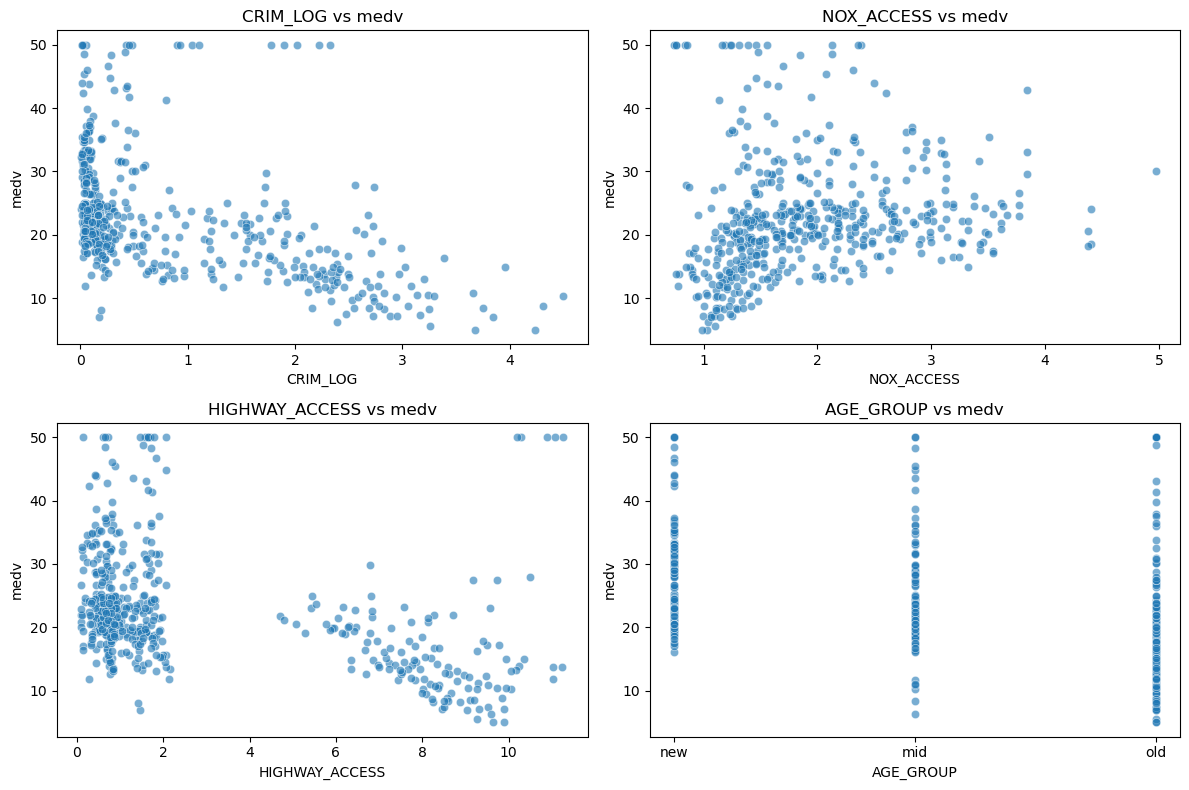

In [25]:
plt.figure(figsize=(12, 8))
for i, feat in enumerate(new_features[:4], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=feat, y='medv', data=engineered_df, alpha=0.6)
    plt.title(f"{feat} vs medv")
plt.tight_layout()
plt.show()

### Feature Selection

#### Prepare data for modeling

In [26]:
X = pd.get_dummies(engineered_df.drop('medv', axis=1))
y = engineered_df['medv']

### Recursive Feature Elimination

In [27]:
selector = RFE(LinearRegression(), n_features_to_select=10)
selector.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=10)

### Get selected features

In [28]:
selected_features = X.columns[selector.support_]
print("Selected features:")
print(selected_features.tolist())

Selected features:
['chas', 'nox', 'rm', 'ptratio', 'lstat', 'ROOMS_PER_TAX', 'NOX_ACCESS', 'CRIM_LOG', 'HIGHWAY_ACCESS', 'AGE_GROUP_mid']


###  Performance Evaluation

#### Split data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42
)

## Baseline model (original features)

In [32]:
original_features = ['CRIM_LOG', 'rm', 'lstat', 'ptratio', 'nox']
baseline = LinearRegression().fit(X_train[original_features], y_train)
baseline_pred = baseline.predict(X_test[original_features])

### Engineered model

In [33]:
improved = LinearRegression().fit(X_train, y_train)
improved_pred = improved.predict(X_test)

# Compare results

In [34]:
results = pd.DataFrame({
    'Metric': ['MSE', 'R2'],
    'Baseline': [
        mean_squared_error(y_test, baseline_pred),
        r2_score(y_test, baseline_pred)
    ],
    'Improved': [
        mean_squared_error(y_test, improved_pred),
        r2_score(y_test, improved_pred)
    ]
})

print("Performance Comparison:")
results['Improvement'] = ((results['Improved'] - results['Baseline']) / results['Baseline']) * 100
display(results)

Performance Comparison:


,Metric,Baseline,Improved,Improvement
0,MSE,27.483229,20.432828,-25.653466
1,R2,0.625231,0.721372,15.376915


## Save Engineered Features

#### Save processed data

In [36]:
# First ensure we have the one-hot encoded version
final_features = pd.get_dummies(engineered_df)[selected_features]

# Save processed data
final_features.to_csv("../data/processed/X_engineered.csv", index=False)
engineered_df['medv'].to_csv("../data/processed/y_engineered.csv", index=False)

# Save feature list
with open("../models/selected_features.txt", "w") as f:
    f.write("\n".join(selected_features))

In [38]:
# create one-hot encoded version
X_encoded = pd.get_dummies(engineered_df)

# Verify all selected features exist
missing_features = [f for f in selected_features if f not in X_encoded.columns]
if missing_features:
    print(f"Warning: Missing features {missing_features} - removing from selection")
    selected_features = [f for f in selected_features if f in X_encoded.columns]

# Save processed data
X_encoded[selected_features].to_csv("../data/processed/X_engineered.csv", index=False)
engineered_df['medv'].to_csv("../data/processed/y_engineered.csv", index=False)

# Save feature list
with open("../models/selected_features.txt", "w") as f:
    f.write("\n".join(selected_features))